# NLP Vectorization

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import pandas as pd
import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk import pos_tag
from nltk.corpus import wordnet
import matplotlib.pyplot as plt
import string
import re

# Notice that these vectorizers are from `sklearn` and not `nltk`!
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer,\
HashingVectorizer

## Learning Goals

SWBAT:

- normalize a lexicon with stemming and lemmatization
- run feature engineering algorithms for NLP
    - bag-of-Words
    - vectorization

In [2]:
corpus = pd.read_csv('data/satire_nosatire.csv')
first_document = corpus.iloc[0].body
manual_cleanup = [word.lower() for word in first_document.split(' ')]
manual_cleanup = [s.translate(str.maketrans('', '', string.punctuation))\
                  for s in manual_cleanup]
sw = stopwords.words('english')
manual_cleanup = [token for token in manual_cleanup if\
                  token not in sw]

LookupError: 
**********************************************************************
  Resource [93mstopwords[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('stopwords')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mcorpora/stopwords[0m

  Searched in:
    - '/Users/Rob/nltk_data'
    - '/opt/anaconda3/envs/learn-env/nltk_data'
    - '/opt/anaconda3/envs/learn-env/share/nltk_data'
    - '/opt/anaconda3/envs/learn-env/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************


In [3]:
pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
tokenizer = RegexpTokenizer(r"([a-zA-Z]+(?:[’'][a-z]+)?)")
first_doc = tokenizer.tokenize(first_document)
first_doc = [token.lower() for token in first_doc]
first_doc = [token for token in first_doc if token not in sw]

NameError: name 'sw' is not defined

In [4]:
first_doc

['noting',
 'that',
 'the',
 'resignation',
 'of',
 'james',
 'mattis',
 'as',
 'secretary',
 'of',
 'defense',
 'marked',
 'the',
 'ouster',
 'of',
 'the',
 'third',
 'top',
 'administration',
 'official',
 'in',
 'less',
 'than',
 'three',
 'weeks',
 'a',
 'worried',
 'populace',
 'told',
 'reporters',
 'friday',
 'that',
 'it',
 'was',
 'unsure',
 'how',
 'many',
 'former',
 'trump',
 'staffers',
 'it',
 'could',
 'safely',
 'reabsorb',
 'jesus',
 'we',
 'can’t',
 'just',
 'take',
 'back',
 'these',
 'assholes',
 'all',
 'at',
 'once',
 'we',
 'need',
 'time',
 'to',
 'process',
 'one',
 'before',
 'we',
 'get',
 'the',
 'next',
 'said',
 'year',
 'old',
 'gregory',
 'birch',
 'of',
 'naperville',
 'il',
 'echoing',
 'the',
 'concerns',
 'of',
 'million',
 'americans',
 'in',
 'also',
 'noting',
 'that',
 'the',
 'country',
 'was',
 'only',
 'now',
 'truly',
 'beginning',
 'to',
 'reintegrate',
 'former',
 'national',
 'security',
 'advisor',
 'michael',
 'flynn',
 'this',
 'is',
 '

### Stemming and Lemmatizing

#### Stemming
Most of the semantic meaning of a word is held in the root, which is usually the beginning of a word.  Conjugations and plurality do not change the semantic meaning. "eat", "eats", and "eating" all have essentially the same meaning. The rest is grammatical variation for the sake of marking things like tense or person or number.   

Stemmers consolidate similar words by chopping off the ends of the words.

![stemmer](img/stemmer.png)

There are different stemmers available.  The two we will use here are the **Porter** and **Snowball** stemmers.  A main difference between the two is how aggressively it stems, Porter being less aggressive.

In [5]:
p_stemmer = nltk.stem.PorterStemmer()
s_stemmer = nltk.stem.SnowballStemmer(language="english")

In [6]:
first_doc[0]

'noting'

In [7]:
p_stemmer.stem(first_doc[0])

'note'

In [8]:
s_stemmer.stem(first_doc[0])

'note'

In [9]:
for word in first_doc:
    p_word = p_stemmer.stem(word)
    s_word = s_stemmer.stem(word)
    
    if p_word != s_word:
        print(word, p_word, s_word)

was wa was
jesus jesu jesus
can’t can’t can't
naperville napervil napervill
was wa was
this thi this
i’d i’d i'd
trump’s trump’ trump
that’s that’ that
this thi this
has ha has


In [10]:
first_doc = [p_stemmer.stem(word) for word in first_doc]

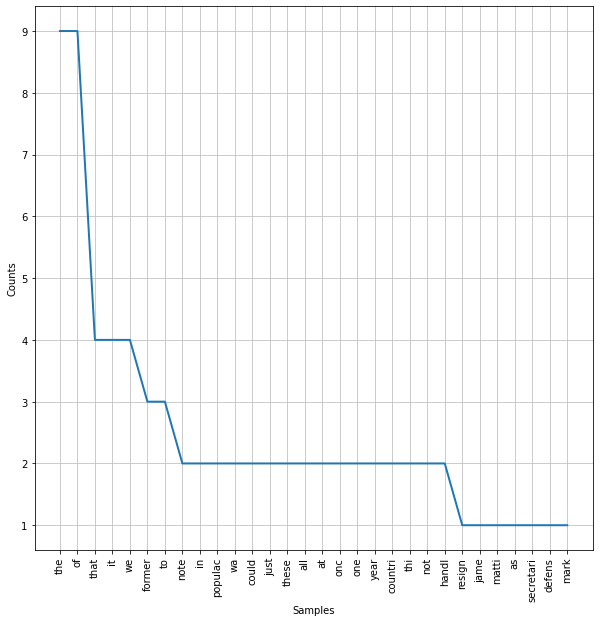

In [11]:
fdist = FreqDist(first_doc)
plt.figure(figsize=(10, 10))
fdist.plot(30);

In [12]:
print(f'Stemming did not reduce our token count: {len(set(first_doc))} unique tokens')

Stemming did not reduce our token count: 111 unique tokens


#### Lemmatizing

Lemmatizing is a bit more sophisticated than the stem choppers. Lemmatizing uses part-of-speech tagging to determine how to transform a word.

- Unlike Stemming, Lemmatization reduces the inflected words, properly ensuring that the root word belongs to the language. It can handle words such as "mouse", whose plural "mice" the stemmers would not lump together with the original. 

- In Lemmatization, the root word is called the "lemma". 

- A lemma (plural lemmas or lemmata) is the canonical form, dictionary form, or citation form of a set of words.

![lemmer](img/lemmer.png)

In [13]:
lemmatizer = nltk.stem.WordNetLemmatizer()

In [14]:
print(f'"Mice" becomes: {lemmatizer.lemmatize("mice")}')
print(f'"Noting" becomes: {lemmatizer.lemmatize(first_doc[0])}')

LookupError: 
**********************************************************************
  Resource [93mwordnet[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('wordnet')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mcorpora/wordnet[0m

  Searched in:
    - '/Users/Rob/nltk_data'
    - '/opt/anaconda3/envs/learn-env/nltk_data'
    - '/opt/anaconda3/envs/learn-env/share/nltk_data'
    - '/opt/anaconda3/envs/learn-env/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************


In [15]:
# However, look at the output below:
    
sentence = "He saw the trees get sawed down"
lemmed_sentence = [lemmatizer.lemmatize(token) for token in sentence.split(' ')]
lemmed_sentence

LookupError: 
**********************************************************************
  Resource [93mwordnet[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('wordnet')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mcorpora/wordnet[0m

  Searched in:
    - '/Users/Rob/nltk_data'
    - '/opt/anaconda3/envs/learn-env/nltk_data'
    - '/opt/anaconda3/envs/learn-env/share/nltk_data'
    - '/opt/anaconda3/envs/learn-env/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************


Lemmatizers depend, for their full functionality, on POS tagging, and **the default tag is 'noun'**.

With a little bit of work, we can POS tag our text.

In [ ]:
pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
tokenizer = RegexpTokenizer(r"([a-zA-Z]+(?:[’'][a-z]+)?)")
first_doc = tokenizer.tokenize(first_document)
first_doc = [token.lower() for token in first_doc]
first_doc = [token for token in first_doc if token not in sw]
corpus.loc[0].body

In [ ]:
nltk.download('tagsets')
nltk.help.upenn_tagset()

In [ ]:
# Use nltk's pos_tag to tag our words
# Does a pretty good job, but does make some mistakes

first_doc_tagged = pos_tag(first_doc)
first_doc_tagged

In [ ]:
# Then transform the tags into the tags of our lemmatizers

def get_wordnet_pos(treebank_tag):
    '''
    Translate nltk POS to wordnet tags
    '''
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [ ]:
first_doc_tagged = [(token[0], get_wordnet_pos(token[1]))
             for token in first_doc_tagged]

In [ ]:
first_doc_tagged

In [ ]:
first_doc_lemmed = [lemmatizer.lemmatize(token[0], token[1]) for token in first_doc_tagged]

In [ ]:
first_doc_lemmed[:10]

In [ ]:
print(f'There are {len(set(first_doc_lemmed))} unique lemmas.')

In [ ]:
fdist = FreqDist(first_doc_lemmed)
plt.figure(figsize=(10, 10))
fdist.plot(30);

## Part 3. Feature Engineering for NLP

The machine learning algorithms we have encountered so far represent features as the variables that take on different value for each observation. For example, we represent individuals with distinct education levels, incomes, and such. However, in NLP, features are represented in a very different way. In order to pass text data to machine learning algorithms and perform classification, we need to represent the features in a sensible way. One such method is called **Bag-of-words (BoW)**.

A bag-of-words model, or BoW for short, is a way of extracting features from text for use in modeling. A bag-of-words is a representation of text that describes the occurrence of words within a document. It involves two things:

- A vocabulary of known words.
- A measure of the presence of known words.

It is called a “bag” of words **because any information about the order or structure of words in the document is discarded**. The model is only concerned with whether known words occur in the document, not with **where** they may occur in the document. The intuition behind BoW is that a document is similar to another if they have similar contents. The Bag of Words method can be represented as a **Document Term Matrix**, in which each column is a unique vocabulary n-gram and each observation is a document. Consider, for example, the following **corpus** of documents:

- Document 1: "I love dogs."
- Document 2: "I love cats."
- Document 3: "I love all animals."
- Document 4: "I hate dogs."

This corpus can be represented as:

$\downarrow$Doc\|Word$\rightarrow$|I|love|dogs|cats|all|animals|hate
-|-|-|-|-|-|-|-
Document_1|1|1|1|0|0|0|0
Document_2|1|1|0|1|0|0|0
Document_3|1|1|0|0|1|1|0
Document_4|1|0|1|0|0|0|1

### Vectorization

In order to get these tokens from our documents, we're going to use tools called "vectorizers".

The most straightforward vectorizer in `sklearn.feature_extraction.text` is the `CountVectorizer`, which will simply count the number of each word type in each document.

#### `CountVectorizer`

In [ ]:
# implementing it in python

# Convert a collection of text documents to a matrix of token counts

vec = CountVectorizer()
X = vec.fit_transform([" ".join(first_doc_lemmed)])


df = pd.DataFrame(X.toarray(), columns=vec.get_feature_names())
df.head()

That is not very exciting for one document. The idea is to make a document term matrix for all of the words in our corpus.

In [ ]:
corpus

In [ ]:
vec = CountVectorizer(token_pattern=r"([a-zA-Z]+(?:'[a-z]+)?)", stop_words=sw)
X = vec.fit_transform(corpus.body[0:2])

df = pd.DataFrame(X.toarray(), columns=vec.get_feature_names())
df.head()

In [ ]:
vec = CountVectorizer(token_pattern=r"([a-zA-Z]+(?:'[a-z]+)?)", stop_words=sw,
                      ngram_range=[1, 2])
X = vec.fit_transform(corpus.body[0:2])

df = pd.DataFrame(X.toarray(), columns=vec.get_feature_names())
df.head()

Our document term matrix gets bigger and bigger, with more and more zeros, becoming sparser and sparser.

In [ ]:
vec = CountVectorizer(token_pattern=r"([a-zA-Z]+(?:'[a-z]+)?)", stop_words=sw,
                      ngram_range=[1, 2])
X = vec.fit_transform(corpus.body)

df = pd.DataFrame(X.toarray(), columns=vec.get_feature_names())
df.head()

In [ ]:
df

We can set upper and lower limits to the word frequency:

In [ ]:
corpus.body

In [ ]:
vec = CountVectorizer(token_pattern=r"([a-zA-Z]+(?:'[a-z]+)?)",
                      stop_words=sw, ngram_range=[1,2],
                      min_df=2, max_df=25)
X = vec.fit_transform(corpus.body)

df_cv = pd.DataFrame(X.toarray(), columns=vec.get_feature_names())
df_cv

#### `TfidfVectorizer`

There are many schemas for determining the values of each entry in a document term matrix, and one of the most common uses the TF-IDF algorithm -- "Term Frequency-Inverse Document Frequency". Essentially, tf-idf *normalizes* the raw count of the document term matrix. And it represents how important a word is in the given document. 

> The goal of using tf-idf instead of the raw frequencies of occurrence of a token in a given document is to scale down the impact of tokens that occur very frequently in a given corpus and that are hence empirically less informative than features that occur in a small fraction of the training corpus.

- TF (Term Frequency)
Term frequency is the frequency of the word in the document divided by the total words in the document.

- IDF (inverse document frequency)
Inverse document frequency is a measure of how much information the word provides, i.e., if it's common or rare across all documents. It is generally calculated as the logarithmically scaled inverse fraction of the documents that contain the word (obtained by dividing the total number of documents by the number of documents containing the term, and then taking the logarithm of that quotient):

$$idf(w) = log (\frac{number\ of\ documents}{num\ of\ documents\ containing\ w})$$

tf-idf is the product of term frequency and inverse document frequency, or tf * idf. 

In [ ]:
tf_vec = TfidfVectorizer(token_pattern=r"([a-zA-Z]+(?:'[a-z]+)?)", stop_words=sw)
X = tf_vec.fit_transform(corpus.body)

df = pd.DataFrame(X.toarray(), columns = tf_vec.get_feature_names())
df.head()

In [ ]:
corpus.iloc[313].body

In [ ]:
df.iloc[313].sort_values(ascending=False)[:10]

Let's compare the tfidf to the count vectorizer output for one document.

In [ ]:
vec = CountVectorizer(token_pattern=r"([a-zA-Z]+(?:'[a-z]+)?)", stop_words=sw)
X = vec.fit_transform(corpus.body)

df_cv = pd.DataFrame(X.toarray(), columns=vec.get_feature_names())
df_cv

In [ ]:
df_cv.iloc[313].sort_values(ascending=False)[:10]

The tfidf lessoned the importance of some of the more common words, including a word, "also", which might have made it into the stopword list.

It also assigns "nerds" more weight than power.  

In [ ]:
print(f'"Nerds" only shows up in document 313: {len(df_cv[df.nerds!=0])} document.')
print(f'"Power" shows up in {len(df_cv[df.power!=0])} documents!')

All the words are stored in a `.vocabulary_` attribute:

In [ ]:
tf_vec.vocabulary_

#### `HashingVectorizer`

There is also a hashing vectorizer, which will encrypt all the words of the corpus.

In [ ]:
hvec = HashingVectorizer(token_pattern=r"([a-zA-Z]+(?:'[a-z]+)?)",
                         stop_words=sw)
X = hvec.fit_transform(corpus.body)

df_cv = pd.DataFrame(X.toarray())
df_cv

Some rules of thumb about these vectorizers:

**Tf-Idf**: Probably the most commonly used. Useful when the goal is to distinguish the **content** of documents from others in the corpus.

**Count**: Useful when the words themselves matter. If the goal is instead about identifying authors by their words, then the fact that some word appears in many documents of the corpus may be important.

**Hashing**: The advantage here is speed and low memory usage. The disadvantage is that you lose the identities of the words being tokenized. Useful for very large datasets where the ultimate model may be a bit of a black box.

## Exercise

For a final exercise, work through the following:

Create a document term matrix of the 1000-document corpus. The vocabulary should have no stopwords, numbers, or punctuation, and it should be lemmatized. Use a `TfidfVectorizer`.